# Apply AI Superresolution to video - Train New Network from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

- See this video for explanation: https://www.youtube.com/watch?v=HEXLlqJQ7Oc


## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places - complete
- different blur levels- complete
- different blur levels in the same image - complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop - use center crop
- crop to the super8 resolution 720x480 or video 320x240 - complete
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam - complete
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution - does not seem to help in convergence

## losses
- try l1 loss - does not converge
- try perceptive loss vgg18 - complete
- perceptive loss uses 256x256 images - too low res, so use overlapping subsets of image to calc loss
- combine perceptive and mse loss
- calculate mse loss on a smoothed version of output compared to input (which is smoothed) - ensure reversal matches


## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation
- get very focused images and use as a validation and test set - prefer one thats published


## Results & Analysis
- Fixes - jpeg artifacts were fixed at one level 30 and slope at 0.01 in:
Superresolution train vdsr with multifuz
Superresolution train vdsr with perception loss multifuz

- mse only goes so far.  too strict
- Perceptual loss helps improve it, but input is 256x256 resolution so limited sharpness.
- Perceptual loss tiled (hires) causes too much causes artifacts
- multifuz improves results especially with perceptual loss, handles different fuzziness better

Next experiment
- training may not need to go as long - complete
- set kernel range from 1 to 20 - vs 4-20 need lower range too - complete
- combination of hi res perceptual and mse on smoothed versions of input.- complete
- give more emphasis to mse

Other ideas
- train on cleaner images div8K
- cascade 2 models.  Train first as usual.  Use it to preprocess input to train second model
- apply mix-up
- better model and apply to all 3 colors - tried, but no improvement.
- try vgg perception metric
- focus prediction


RCAN Results
- Uses lots of resources as scale of image increases
- Does not handle different scales well
- not meant for restoration - 
To try
- Apply pretrained model on a patch thats 48x48 then can judge if its worth making an approach to apply repeatedly to larger images.
- train vdsr with a convolutional upscaling up front, attention, residuals.

UNET results
- Some sharpening but not drastic.  Not better than VDSR
- Used 2x GPU mem than VDSR

New Network results
- Performs as well as VDSR qualitatively, need to check.
- using Div2K gives better results (needs low learning rate)
- try with L1 norm (less noise sensitive)
- add upscale in the middle to allow more flexibility - nn.ConvTranspose2d(in_channels=C, out_channels=M, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
- add  with torch.no_grad():  to validation and prediction with the model to speed up computations.


To Try
- UNET or VDSR with MAXout nonlinear function.  Try different activation functions (mish,etc).
- consistency error measure like fastai superres
- provide input,target  pairs with no fuzziness in the training set.
- Train exclusively on very sharp  images (DIV2K)
- Predict focus as a segmentation in addition to enhancing
- have 3 channel inputs (RGB or ??) and then have 1 channel output
- provide frame-1,frame,frame+1 to predict frame
- opposite of bottleneck - input resolution -> high res -> input res blocks.
- combo of UNET and VDSR
- attention?
- combo of perception and mse measure
- add validation set
- sort dataset into hard cases and easy cases, making cases harder with time.  (train on easy cases first, then fine tune with harder cases)
- make the camera model version of the data loader
- use mse but give more error to perception
- try reflection padding







## Share results
- put out an example on youtube to allow comparison


# Project Documentation

In [1]:

from pathlib import Path
import os


project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"

model_name_base = "MWCNNV2"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train New Network with kernel pred. wavelet v2.1.ipynb


In [4]:
nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder , nb_path.stem )
print(result_path)
os.makedirs(result_path, exist_ok=True)

/SSD_link/superres/Superresolution train New Network with kernel pred. wavelet v2.1.ipynb
/media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1


In [5]:
model_out_path=Path(project_base)/model_folder
print(model_out_path)
os.makedirs(model_out_path, exist_ok=True)

/media/SSD/superres/checkpoint


In [6]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [7]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale,ToPILImage,Normalize

from torchvision.transforms.functional import hflip

import random

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [8]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers

torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [9]:
import fnmatch

In [23]:
from superres_utils import make_framelist, load_frame, RescaleCrop, Multifuz, DatasetFromVideoFolder
from superres_utils import show_batch
from superres_utils import pil_disk_blur, display_PSNR, test_results, superres_mp4

In [24]:
kr = (3,16)
np.int16(random.betavariate(1.5, 1)*(kr[1]-kr[0])+ kr[0])

12

In [25]:



class DatasetFromVideoFolder_d(data.Dataset):
    def __init__(self, video_dir,crop_size,frame_sample_size=10,max_kernel=10,kernel_dist=random.uniform,
                 Flip_hor=True,Rand_bright_contrast=True, input_transform =None,target_transform=None,
                 match_exp="*.*", **camera_params):
        
        #  add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10

        super(DatasetFromVideoFolder_d, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size,match_exp)
        
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.crop_size = crop_size
        self.max_kernel = max_kernel
        self.target_transform = target_transform
        self.camera_params = camera_params
        self.input_transform = input_transform
        
        self.kernel_dist = kernel_dist
        
    def camera_transform(self,img_hr):
        
        # go through the parameters and simulate the camera
        width, height = img_hr.size
               
        crop_top = max(0,int(round((height - self.crop_size[0]) / 2.)))
        crop_bottom = crop_top + self.crop_size[0]
        crop_left = max(0,int(round((width - self.crop_size[1]) / 2.)))
        crop_right = crop_left + self.crop_size[1]
        
        camera_specs = {}
        camera_specs["crop_size"] = np.int16(self.crop_size)
        
        camera_specs["center"] = np.int16((random.uniform(crop_left, crop_right),random.uniform(crop_top, crop_bottom)))
        
        camera_specs["scale"] = np.float32(random.uniform(0.5,2))
       
        
        #camera_specs["kernel_a"] = np.float32(random.uniform(*self.camera_params["kernel_range"]))
        #camera_specs["kernel_b"] = np.float32(random.uniform(*self.camera_params["kernel_range"]))
        
        camera_specs["kernel_a"] = np.int16(self.kernel_dist(*self.camera_params["kernel_range"]))
        camera_specs["kernel_b"] = np.int16(self.kernel_dist(*self.camera_params["kernel_range"]))
        camera_specs["quality"] = np.int16(random.uniform(*self.camera_params["quality_range"]))
        camera_specs["slope"] = np.float32(random.uniform(*self.camera_params["slope_range"]))
        camera_specs["radius"] = np.float32(random.uniform(*self.camera_params["radius_range"])*max(self.crop_size[0],self.crop_size[1]))
        
        img_lr = Multifuz(**camera_specs)(img_hr)
        return img_lr, camera_specs

    def __getitem__(self, index):
        img_hr = load_frame(self.video_frames[index])
        if self.crop_size is not None:
            img_hr = RescaleCrop(self.crop_size,self.max_kernel )(img_hr)
        
        if self.Flip_hor:
            img_hr = RandomHorizontalFlip()(img_hr)
        
        if self.Rand_bright_contrast:
            img_hr = ColorJitter(brightness=.2, contrast=.2)(img_hr)
        
        

        
        # go through the parameters and simulate the camera
        img_lr,camera_specs = self.camera_transform(img_hr)
            
        
        if self.input_transform:
            img_lr = self.input_transform(img_lr)
        
        if self.target_transform:
            img_hr = self.target_transform(img_hr)
            
        #print(camera_specs)
        return img_lr, img_hr, camera_specs

    def __len__(self):
        return len(self.video_frames)

In [26]:
def input_transform():        
    return Compose([        
        #Grayscale(num_output_channels=1),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])



def target_transform(crop_size):
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])


In [34]:
def beta_rand(k_min,k_max):
            return np.int16(random.betavariate(1.5, 1)*(k_max-k_min)+ k_min)

In [65]:
#train_dir = "/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR"
train_dir = "/home/filip/SSD_link/superres/video_data/train_data"
frame_sample_size =30
batch_size = 4 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
#crop_size = (256,256)

kernel_dist = beta_rand
kernel_range=(3,16)
max_kernel = 16
quality_range=(30,90) 
slope_range=(0.001, 0.1)
#radius_range=(0,0)  # make all one fuzziness
radius_range=(.5,1)  
scale_range=(1/2,2)
Flip_hor=True
Rand_bright_contrast=False

In [66]:
train_set = DatasetFromVideoFolder_d(train_dir,crop_size,frame_sample_size,
                                    max_kernel=max_kernel,
                                    kernel_dist=kernel_dist,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range,
                                   
                            )
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

In [67]:
valid_dir = "/home/filip/SSD_link/superres/DIV2K/DIV2K_valid_HR"
#frame_sample_size =10
#batch_size = 4 # Make 4 For FP16, 480x720 size images
#crop_size = (480,720)

kernel_range=(1,16)
quality_range=(30,99) 
slope_range=(0.001, 0.1)
radius_range=(0,0)  # make all one fuzziness
scale_range=(1/2,2)
Flip_hor=False
Rand_bright_contrast=False
match_exp = "*.*"

In [68]:
valid_set = DatasetFromVideoFolder_d(valid_dir,crop_size,frame_sample_size,
                                    max_kernel=max_kernel,
                                     kernel_dist=kernel_dist,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                    match_exp=match_exp,
                                    
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range
                                   
                                   
                            )
valid_data_loader = DataLoader(dataset=valid_set, num_workers=0, batch_size=batch_size, shuffle=False)

In [69]:
from superres_utils import variance_of_laplacian

def show_batch(dataloader,size = 8, denormalize = True):

    inputs, outputs, camera_specs = next(iter(dataloader))
    
    if type(inputs) is list:
        columns = len(inputs) + 1
        rows = len(inputs[0])
    else:
        columns = 2
        rows = len(inputs)
        
    #print("rows =",rows,"cols=",columns)
         
        
    #print(inputs.shape)
    #inputs = inputs.numpy().transpose((0, 2, 3, 1))
    #outputs = outputs.numpy().transpose((0, 2, 3, 1))
    #print(camera_specs)
    
    mn = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = columns*size, rows*size
    fig=plt.figure(figsize=(w, h))
    
    ax=[]
    
   
    for i in range(0, rows):
        
        for j in range(0, columns):
            if type(inputs) is list:
                if j< (columns - 1):
                    img = inputs[j][i].numpy().transpose((1,2,0))
                    if denormalize: img = img*std + mn
                else:
                    img = outputs[i].numpy().transpose((1,2,0))
                    
            else:
                if j == 0:
                    img = inputs[i].numpy().transpose((1,2,0))
                    if denormalize: img = img*std + mn
                else:
                    img = outputs[i].numpy().transpose((1,2,0))
                
            blur_measure = variance_of_laplacian((img*255).astype(np.uint8))
            
            ax.append(fig.add_subplot(rows, columns, (columns)*i + j +1))
            ax[-1].set_title('Blur: '+str(blur_measure))
            plt.imshow((img*255).astype(np.uint8),cmap='gray')
    plt.show()

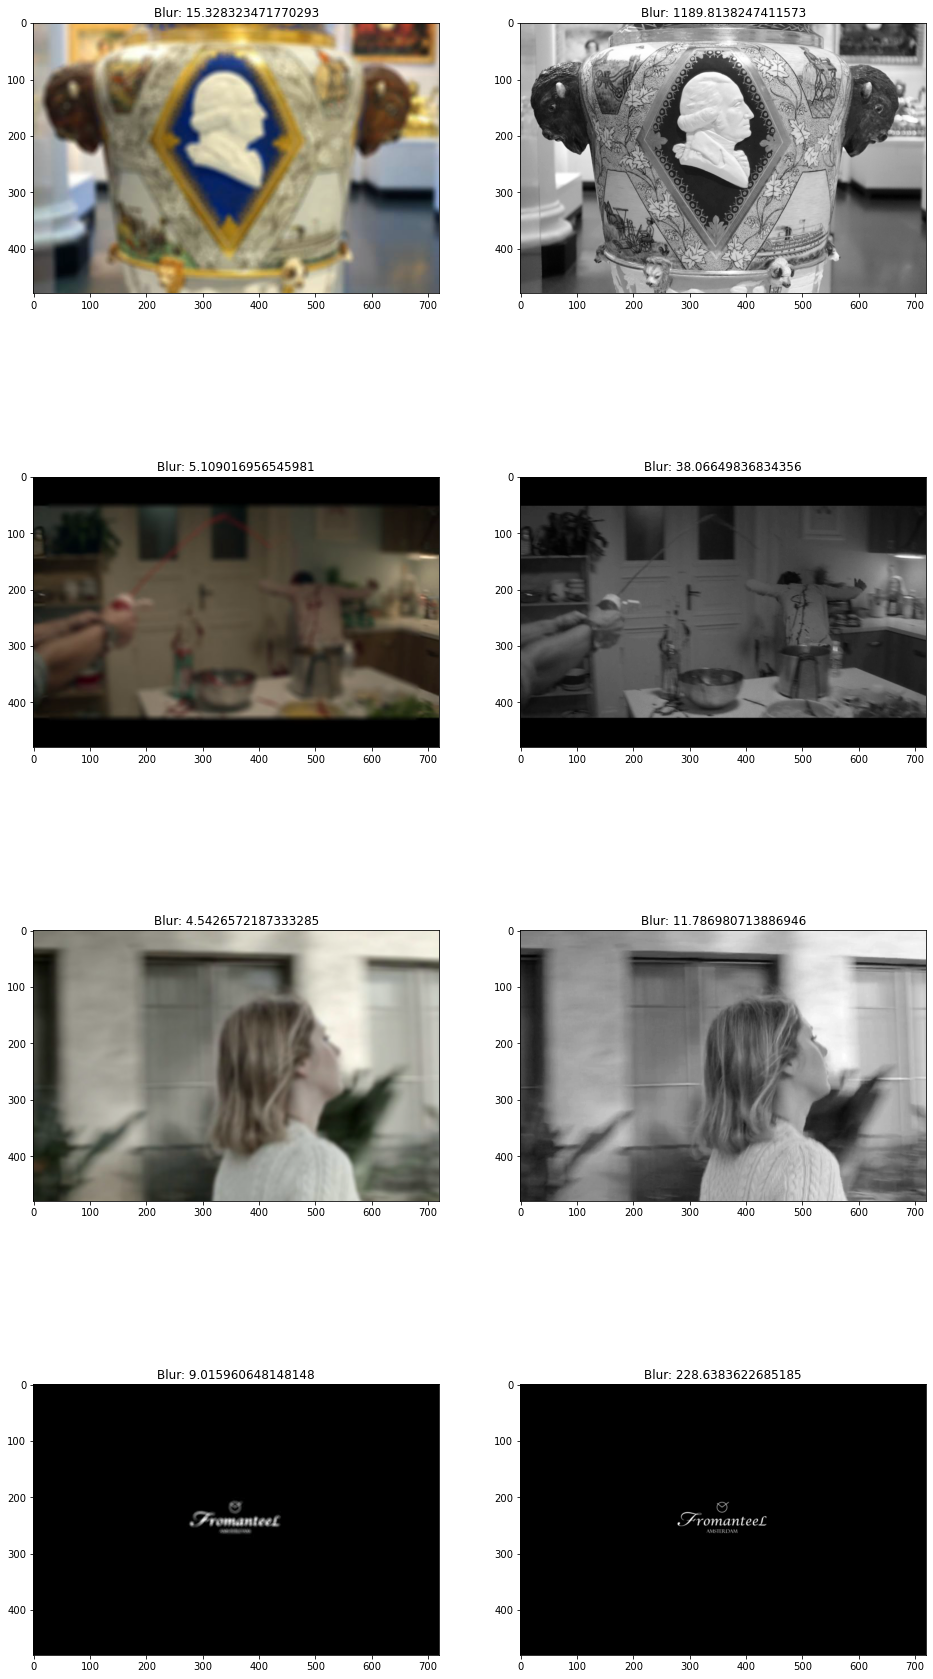

In [70]:
show_batch(training_data_loader,size =8, denormalize = True)

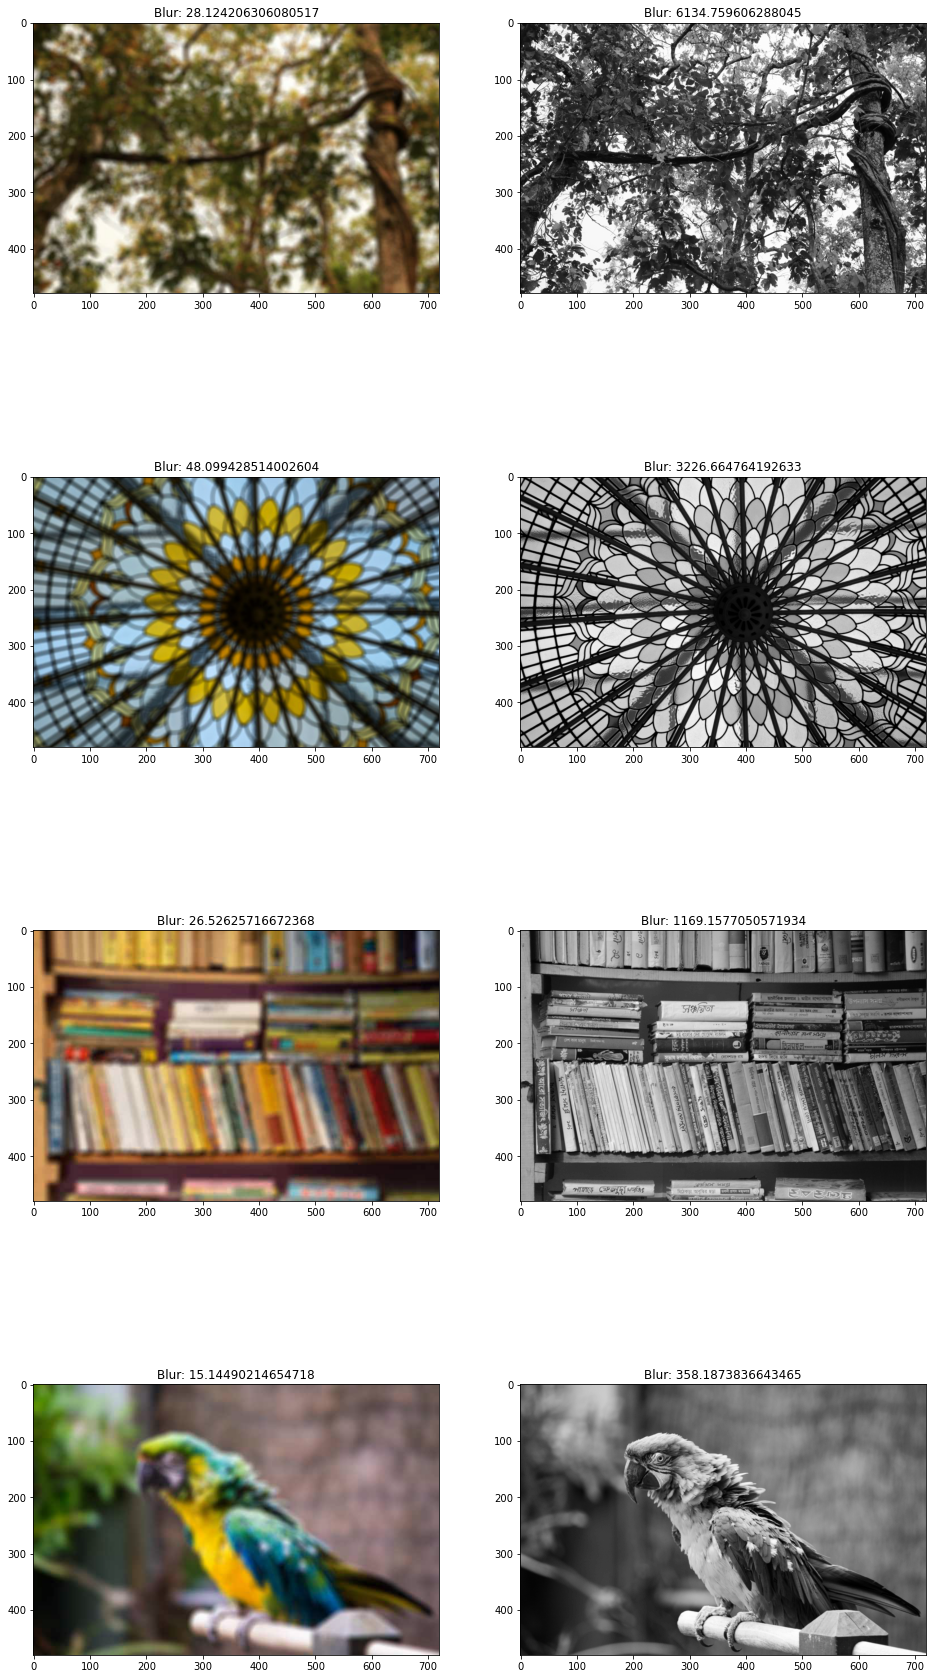

In [71]:
show_batch(valid_data_loader,size =8, denormalize = True)

In [ ]:
# try using kornia to blur the high res output and compare to input

In [ ]:
import kornia
from superres_utils import tophat2D

In [ ]:
def tensor_disk_blur(img_t, kernel_width):
    k = tophat2D(int(kernel_width)/2.0)
    k = torch.from_numpy(k).unsqueeze(0)
    
    return kornia.filter2D(img_t.unsqueeze(0), k, border_type="reflect").squeeze(0)

In [ ]:
def rgb_to_grayscale(img, num_output_channels = 1):
    

    r, g, b = img.unbind(dim=-3)
    # This implementation closely follows the TF one:
    # https://github.com/tensorflow/tensorflow/blob/v2.3.0/tensorflow/python/ops/image_ops_impl.py#L2105-L2138
    l_img = (0.2989 * r + 0.587 * g + 0.114 * b).to(img.dtype)
    l_img = l_img.unsqueeze(dim=-3)

    if num_output_channels == 3:
        return l_img.expand(img.shape)

    return l_img

In [ ]:
class Inverse_Loss(torch.nn.Module):
    # Takes the network's output and applies fuzzy kernel (an inverse of the network).
    # Then compares with the input which is fuzzy
    # We would expect that these should match
    # This is a measure of consistency
    
    def __init__(self):
        super(Inverse_Loss,self).__init__()
        self.lossfn = nn.MSELoss(reduction = 'mean')
        mn = [0.485, 0.456, 0.406]
        st = [0.229, 0.224, 0.225]
        
        
        self.mn = torch.as_tensor(mn).cuda().view(-1, 1, 1)
        self.st = torch.as_tensor(st).cuda().view(-1, 1, 1)
        
    
    
    
    def forward(self,inpt,outpt,k):
        
        inpt2 = inpt.mul(self.st).add(self.mn)
        inpt2 = rgb_to_grayscale(inpt2)
        outpt2 = outpt.clone()
        
        for i in range(0,len(outpt)):
            
            #outpt[i] = batch_disk_blur(outpt[i], k[i])
            outpt2[i] = tensor_disk_blur(outpt[i],  k[i])
                             
        
        totloss = 50 * self.lossfn.forward(inpt2,outpt2)
        #print("total:",totloss)
        
        return totloss


# MWCNN

In [56]:
import common
import torch.nn as nn

def rgb_to_grayscale(img, num_output_channels = 1):
    

    r, g, b = img.unbind(dim=-3)
    # This implementation closely follows the TF one:
    # https://github.com/tensorflow/tensorflow/blob/v2.3.0/tensorflow/python/ops/image_ops_impl.py#L2105-L2138
    l_img = (0.2989 * r + 0.587 * g + 0.114 * b).to(img.dtype)
    l_img = l_img.unsqueeze(dim=-3)

    if num_output_channels == 3:
        return l_img.expand(img.shape)

    return l_img

class MWCNN(nn.Module):
    def __init__(self, n_feats, nColor , conv=common.default_conv):
        super(MWCNN, self).__init__()
        kernel_size = 3
        self.scale_idx = 0

        act = nn.ReLU(True)

        self.DWT = common.DWT()
        self.IWT = common.IWT()

        n = 1
        m_head = [common.BBlock(conv, nColor, n_feats, kernel_size, act=act)]
        d_l0 = []
        d_l0.append(common.DBlock_com1(conv, n_feats, n_feats, kernel_size, act=act, bn=False))


        d_l1 = [common.BBlock(conv, n_feats * 4, n_feats * 2, kernel_size, act=act, bn=False)]
        d_l1.append(common.DBlock_com1(conv, n_feats * 2, n_feats * 2, kernel_size, act=act, bn=False))

        d_l2 = []
        d_l2.append(common.BBlock(conv, n_feats * 8, n_feats * 4, kernel_size, act=act, bn=False))
        d_l2.append(common.DBlock_com1(conv, n_feats * 4, n_feats * 4, kernel_size, act=act, bn=False))
        pro_l3 = []
        pro_l3.append(common.BBlock(conv, n_feats * 16, n_feats * 8, kernel_size, act=act, bn=False))
        pro_l3.append(common.DBlock_com(conv, n_feats * 8, n_feats * 8, kernel_size, act=act, bn=False))
        pro_l3.append(common.DBlock_inv(conv, n_feats * 8, n_feats * 8, kernel_size, act=act, bn=False))
        pro_l3.append(common.BBlock(conv, n_feats * 8, n_feats * 16, kernel_size, act=act, bn=False))

        i_l2 = [common.DBlock_inv1(conv, n_feats * 4, n_feats * 4, kernel_size, act=act, bn=False)]
        i_l2.append(common.BBlock(conv, n_feats * 4, n_feats * 8, kernel_size, act=act, bn=False))

        i_l1 = [common.DBlock_inv1(conv, n_feats * 2, n_feats * 2, kernel_size, act=act, bn=False)]
        i_l1.append(common.BBlock(conv, n_feats * 2, n_feats * 4, kernel_size, act=act, bn=False))

        i_l0 = [common.DBlock_inv1(conv, n_feats, n_feats, kernel_size, act=act, bn=False)]

        m_tail = [conv(n_feats, nColor, kernel_size)]

        self.head = nn.Sequential(*m_head)
        self.d_l2 = nn.Sequential(*d_l2)
        self.d_l1 = nn.Sequential(*d_l1)
        self.d_l0 = nn.Sequential(*d_l0)
        self.pro_l3 = nn.Sequential(*pro_l3)
        self.i_l2 = nn.Sequential(*i_l2)
        self.i_l1 = nn.Sequential(*i_l1)
        self.i_l0 = nn.Sequential(*i_l0)
        self.tail = nn.Sequential(*m_tail)

    def forward(self, x):
        x = rgb_to_grayscale(x)
        x0 = self.d_l0(self.head(x))
        x1 = self.d_l1(self.DWT(x0))
        x2 = self.d_l2(self.DWT(x1))
        x_ = self.IWT(self.pro_l3(self.DWT(x2))) + x2
        x_ = self.IWT(self.i_l2(x_)) + x1
        x_ = self.IWT(self.i_l1(x_)) + x0
        x = self.tail(self.i_l0(x_)) + x

        return x

    def set_scale(self, scale_idx):
        self.scale_idx = scale_idx

# build the model

In [57]:
model = torch.load("/media/SSD/superres/checkpoint/MWCNNV2_epoch_24.pth")["model"]
#model = NEWNet8(c1=64,c2=128, c3=1024)
#model = MWCNN(n_feats=64, nColor=1)
model.cuda()

MWCNN(
  (DWT): DWT()
  (IWT): IWT()
  (head): Sequential(
    (0): BBlock(
      (body): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
  )
  (d_l2): Sequential(
    (0): BBlock(
      (body): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (1): DBlock_com1(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
  )
  (d_l1): Sequential(
    (0): BBlock(
      (body): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (1): DBlock_com1(
      (body): Sequential(
        (0): Conv2d(128, 128,

In [60]:
def loss_scaler(im):
    # scale to -1,1 and convert to 3 channel (greyscale to RBG)
    return (im * 2 - 1).expand(-1, 3, -1, -1)

In [61]:
class Pixel_Loss(torch.nn.Module):
    
    def __init__(self):
        super(Pixel_Loss,self).__init__()
        self.lossfn = nn.MSELoss(reduction = 'mean')
        
        self.percep_loss_fn = lpips.LPIPS(net='alex').cuda()


    #def forward(self,x,y):
        
     #   return self.num_pixels*(self.lossfn.forward(x,y))
    
    
    def forward(self,x,y):
        
        totloss = torch.mean(self.percep_loss_fn.forward(loss_scaler(x),loss_scaler(y)))
        #print("perceptual:",totloss)
        
        totloss.add_(50 * self.lossfn.forward(x,y))
        #print("total:",totloss)
        
        return totloss


In [63]:
criterion = Pixel_Loss()
#criterion = nn.L1Loss(reduction = 'mean')





Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /media/SSD/conda_env/superres/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [64]:
init_lr = 3.16e-6
lr_step = 6
gradient_clip = 0.4
epoch_start = 25
epochs = 12

loops = 1

In [72]:

optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)
#optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=0)



In [73]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [74]:
def save_checkpoint(experiment, model, epoch, valid_error):

    model_out_str = str(model_out_path/(model_name_base+"_epoch_{}.pth")).format(epoch)
    
    state = {"experiment": experiment, "epoch": epoch ,"model": model, "valid_error": valid_error}

    torch.save(state, model_out_str)

    print("Checkpoint saved to {}".format(model_out_str))

In [75]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
#import kornia


In [76]:
from torch.optim.swa_utils import AveragedModel
swa_model = torch.optim.swa_utils.AveragedModel(model)

In [77]:
def trainfp16(training_data_loader, optimizer, model,  epoch,scaler, loops):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-epoch_start)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    
    cum_loss = 0
    ct=0  ##need to use a different variable.
    ct2=0

    pbar = tqdm(total=loops*len(training_data_loader))
    for loop_count in range(loops):  
        for iteration, batch in enumerate(training_data_loader, 1):
            inpt_list, target, camera_specs = batch[0], batch[1], batch[2]
            
            in0 = inpt_list.cuda()
           # inm1 = inpt_list[1].cuda()
           # inp1 = inpt_list[2].cuda()
           # k_target = (camera_specs["kernel_a"].float())

            target = target.cuda()
            
           # with torch.no_grad():
           #     with autocast():
           #         k_pred = kmodel(in0)
            
            
            #k_target = (camera_specs["kernel_a"].float()).cuda()

            optimizer.zero_grad()

            # Runs the forward pass with autocasting.
            with autocast():
                output = model(in0)
                loss = criterion(output, target)

            #print("Loss =",loss)
            
            scaler.scale(loss).backward()
            #loss.backward() 

            # Unscales the gradients of optimizer's assigned params in-place
            #scaler.unscale_(optimizer)

            #nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 

            #optimizer.step()
            scaler.step(optimizer)

            if epoch>1:
                swa_model.update_parameters(model)

            # Updates the scale for next iteration.
            scaler.update()

            #scheduler.step()

            cum_loss = cum_loss + loss.data


            ct = ct +1 



            pbar.update(1)
    pbar.close()    
   
    print("Epoch Loss:", cum_loss/ct)        

In [78]:
def validatefp16(valid_data_loader, model,   loop=10):

    model.eval()
    cum_loss2=0
    cum_loss1 = 0
    ct=0 
    
    with torch.no_grad():
        for r in trange(loop):
            for iteration, batch in enumerate(valid_data_loader, 1):
                inpt_list, target, camera_specs = batch[0], batch[1], batch[2]

                in0 = inpt_list.cuda()
                #inm1 = inpt_list[1].cuda()
                #inp1 = inpt_list[2].cuda()
                

                target = target.cuda()
                
                
                #with autocast():
                #    k_pred = kmodel(in0)
                
                #k_target = (camera_specs["kernel_a"].float()).cuda()
                
                # Runs the forward pass with autocasting.
                with autocast():
                    output = model(in0)
                    loss1 = criterion(output, target)
                    #loss2 = criterionk(k_pred[:,0],k_target)

                #print(k_pred[:,0].shape, k_target.shape)
               
                cum_loss1 = cum_loss1 + loss1.data
                #cum_loss2 = cum_loss2 + loss2.data

                ct = ct + 1 ## Used to be batch_size





        print("===> Epoch Validation Loss: {:.10f}".format(cum_loss1/ct) )
    
    return (cum_loss1/ct).item()

In [79]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(epoch_start, epochs+epoch_start):
        trainfp16(training_data_loader, optimizer, model,  epoch,scaler,loops)
        valid_error = validatefp16(valid_data_loader, model,loop=10)
        save_checkpoint(NOTEBOOK_FULL_PATH, model, epoch, valid_error)

  0%|          | 0/4951 [00:00<?, ?it/s]

Start Time: 2020-12-05 07:28:55.772605
Epoch = 25, lr = 3.16e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2778, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5156250000
Checkpoint saved to /media/SSD/superres/checkpoint/MWCNNV2_epoch_25.pth
Start Time: 2020-12-05 09:38:35.239864
Epoch = 26, lr = 3.16e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2852, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5048828125
Checkpoint saved to /media/SSD/superres/checkpoint/MWCNNV2_epoch_26.pth
Start Time: 2020-12-05 11:46:29.969415
Epoch = 27, lr = 3.16e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2844, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5175781250
Checkpoint saved to /media/SSD/superres/checkpoint/MWCNNV2_epoch_27.pth
Start Time: 2020-12-05 13:54:23.953830
Epoch = 28, lr = 3.16e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2781, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5073242188
Checkpoint saved to /media/SSD/superres/checkpoint/MWCNNV2_epoch_28.pth
Start Time: 2020-12-05 16:01:58.636989
Epoch = 29, lr = 3.16e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2795, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.4936523438
Checkpoint saved to /media/SSD/superres/checkpoint/MWCNNV2_epoch_29.pth
Start Time: 2020-12-05 18:09:33.686168
Epoch = 30, lr = 3.16e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2783, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.4975585938
Checkpoint saved to /media/SSD/superres/checkpoint/MWCNNV2_epoch_30.pth
Start Time: 2020-12-05 20:17:29.578812
Epoch = 31, lr = 9.99279740613208e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2710, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.4953613281
Checkpoint saved to /media/SSD/superres/checkpoint/MWCNNV2_epoch_31.pth
Start Time: 2020-12-05 22:25:17.148512
Epoch = 32, lr = 9.99279740613208e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2747, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.5014648438
Checkpoint saved to /media/SSD/superres/checkpoint/MWCNNV2_epoch_32.pth
Start Time: 2020-12-06 00:32:56.539199
Epoch = 33, lr = 9.99279740613208e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2751, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.4843750000
Checkpoint saved to /media/SSD/superres/checkpoint/MWCNNV2_epoch_33.pth
Start Time: 2020-12-06 02:40:43.166141
Epoch = 34, lr = 9.99279740613208e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2786, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.4953613281
Checkpoint saved to /media/SSD/superres/checkpoint/MWCNNV2_epoch_34.pth
Start Time: 2020-12-06 04:48:26.406349
Epoch = 35, lr = 9.99279740613208e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2761, device='cuda:0', dtype=torch.float16)


  0%|          | 0/4951 [00:00<?, ?it/s]

===> Epoch Validation Loss: 0.4748535156
Checkpoint saved to /media/SSD/superres/checkpoint/MWCNNV2_epoch_35.pth
Start Time: 2020-12-06 06:56:20.584627
Epoch = 36, lr = 9.99279740613208e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Loss: tensor(0.2764, device='cuda:0', dtype=torch.float16)


100%|██████████| 10/10 [03:00<00:00, 18.06s/it]

===> Epoch Validation Loss: 0.4929199219
Checkpoint saved to /media/SSD/superres/checkpoint/MWCNNV2_epoch_36.pth


In [ ]:
#model = torch.load("/media/SSD/superres/checkpoint/MWCNNV2_epoch_24.pth")["model"]

In [80]:
mcombine = model

# convert sample videos

In [81]:
from superres_utils import decolorize_cv, colorize_cv, cv_center_crop

In [82]:
def cv2_to_batch_tensor(img_bgr):
    mn=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    im_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    im_rgb = im_rgb/255.0
    im_rgb = (im_rgb-mn)/std
    tform = im_rgb.transpose(( 2,0, 1))
    tform = torch.from_numpy(tform).float()
    tform = tform.unsqueeze(0)
    return tform

In [83]:
def batch_tensor_to_cv2(bt_3ch):
    bt_3ch = (bt_3ch*255.0).clamp(0,255)
    t_3ch = bt_3ch.squeeze(0)
    #t_3ch = t_3ch.cpu()
    im_rbg = t_3ch.permute(1,2,0).numpy().astype(np.uint8)
    im_bgr = cv2.cvtColor(im_rbg, cv2.COLOR_RGB2BGR)
    
    return im_bgr

In [84]:

def gs_batch_tensor_to_bgr_cv2(bt_1ch, frame):
    ##convert greyscale batch tensor to bgr cv2
    
    bt_1ch = (bt_1ch*255.0).clamp(0,255)
    t_1ch = bt_1ch.squeeze(0)
    #t_3ch = t_3ch.cpu()
    im_h_y = t_1ch.numpy().astype(np.float32)
    
    im_y, im_b_ycbcr = decolorize_cv(frame) 
    
    im_h_y = im_h_y[0,:,:]

    im_h = colorize_cv(im_h_y, im_b_ycbcr)
    
    return im_h



In [85]:
from superres_utils import decolorize_cv, colorize_cv, cv_center_crop

from torch.cuda.amp import autocast
def superres_mp3_1(infile, outfile, model, channels = 3,factor=1.0,display=True,
                 bitrate= "12000k",errorfile = None, k_scale = 1, center_crop = None, bar_chart = True):
    
    mn=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    
    circ_buffer=[0,0,0]
    circ_ind = 0
    circ_count = 0
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    if center_crop is None:
        width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
    else:
        width,height = center_crop
    
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(errorfile,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    k_preds = []
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            #crop frame if needed
            if center_crop is not None:
                frame = cv_center_crop(frame,(height,width))
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            
            im_input = cv2_to_batch_tensor(frame)


            im_input = im_input.cuda()
            
                
            with torch.no_grad():
                with autocast():
                    mout = model(im_input)  

                
            out=mout.cpu()



            im_h = batch_tensor_to_cv2(out)
            ##convert from greyscale to color
            im_h = gs_batch_tensor_to_bgr_cv2(out,frame)


            #Add notation and crude bar chart to video frame

            


            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            
            # Add special case for last frame here otherwise last frame is lost
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

In [86]:
result_path

PosixPath('/media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1')

In [87]:
from superres_utils import ffmpeg_side_by_side

In [88]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = result_path/"super8.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp3_1(infile, outfile, mcombine,channels=3, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/super8_best_from_mp2.mp4
frames= 7195 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1/super8.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 7195/7195 [10:10<00:00, 11.78it/s]


True

In [89]:

dualfile = str(result_path/"super8dual.mp4")

ffmpeg_side_by_side(infile, outfile, dualfile, resize="Right")

['ffmpeg',
 '-y',
 '-i',
 '/media/SSD/superres/super8/super8_best_from_mp2.mp4',
 '-i',
 '/media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1/super8.mp4',
 '-filter_complex',
 '[0:v] scale=-1:480, pad=1470:500:10:10:gray [left]; [left][1:v] overlay=740:10',
 '-b:v',
 '4000k',
 '/media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1/super8dual.mp4']

In [90]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.3/super8.mp4"
outfile = str(result_path/"super8.mp4")
dualfile= str(result_path/"super8-tolast-dual.mp4")
ffmpeg_side_by_side(infile, outfile, dualfile, resize="Right")

['ffmpeg',
 '-y',
 '-i',
 '/media/SSD/superres/Results/Superresolution train New Network with kernel predictor input v3.3/super8.mp4',
 '-i',
 '/media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1/super8.mp4',
 '-filter_complex',
 '[0:v] scale=-1:480, pad=1470:500:10:10:gray [left]; [left][1:v] overlay=740:10',
 '-b:v',
 '4000k',
 '/media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1/super8-tolast-dual.mp4']

In [91]:


infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-16.mp4"
superres_mp3_1(infile, outfile, mcombine,channels=3, factor=1.6,display=False,bitrate= "4000k")

  0%|          | 2/900 [00:00<01:09, 12.96it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1/muffins30sec-16.mp4
factor: 1.6 
width= 512 
height= 384 
bitrate= 4000k


100%|██████████| 900/900 [00:44<00:00, 20.38it/s]


True

In [92]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-10.mp4"
superres_mp3_1(infile, outfile, mcombine,channels=3, factor=1.0,display=False,bitrate= "4000k")

  1%|          | 5/900 [00:00<00:19, 45.23it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1/muffins30sec-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k


100%|██████████| 900/900 [00:18<00:00, 47.52it/s]


True

In [93]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-20.mp4"
superres_mp3_1(infile, outfile, mcombine,channels=3, factor=2.0,display=False,bitrate= "4000k")

  0%|          | 0/900 [00:00<?, ?it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1/muffins30sec-20.mp4
factor: 2.0 
width= 640 
height= 480 
bitrate= 4000k


100%|██████████| 900/900 [01:09<00:00, 12.93it/s]


True

In [94]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-30.mp4"
superres_mp3_1(infile, outfile, mcombine,channels=3, factor=3.0,display=False,bitrate= "4000k")


  0%|          | 0/900 [00:00<?, ?it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1/muffins30sec-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


100%|██████████| 900/900 [02:29<00:00,  6.01it/s]


True

In [95]:
dualfile= str(result_path/"muffins30sec-30dual.mp4")

ffmpeg_side_by_side(infile, outfile, dualfile, resize="Right")

['ffmpeg',
 '-y',
 '-i',
 '/media/SSD/superres/muffins30sec.mp4',
 '-i',
 '/media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1/muffins30sec-30.mp4',
 '-filter_complex',
 '[0:v] scale=-1:720, pad=1950:740:10:10:gray [left]; [left][1:v] overlay=980:10',
 '-b:v',
 '4000k',
 '/media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1/muffins30sec-30dual.mp4']

In [96]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = str(result_path/"super8long.mp4")
error_file = "/media/SSD/superres/error.txt"
superres_mp3_1(infile, outfile, mcombine,channels=3, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

  0%|          | 0/121409 [00:00<?, ?it/s]

Original File: /media/SSD/superres/super8/Old 8mm Reels_1.mp4
frames= 121409 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1/super8long.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 121409/121409 [2:47:19<00:00, 12.09it/s] 


True

In [97]:
dualfile= str(result_path/"super8longdual.mp4")

ffmpeg_side_by_side(infile, outfile, dualfile, resize="Right")

['ffmpeg',
 '-y',
 '-i',
 '/media/SSD/superres/super8/Old 8mm Reels_1.mp4',
 '-i',
 '/media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1/super8long.mp4',
 '-filter_complex',
 '[0:v] scale=-1:480, pad=1470:500:10:10:gray [left]; [left][1:v] overlay=740:10',
 '-b:v',
 '4000k',
 '/media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1/super8longdual.mp4']

In [98]:

infile = "/media/SSD/superres/Old VHS-C movies Raw WMV files/completed/1987 first video making muffins.wmv"
outfile = result_path/"muffinslong-30.mp4"
superres_mp3_1(infile, outfile, mcombine,channels=3, factor=3.0,display=False,bitrate= "4000k")

  0%|          | 0/50062 [00:00<?, ?it/s]

Original File: /media/SSD/superres/Old VHS-C movies Raw WMV files/completed/1987 first video making muffins.wmv
frames= 50062 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1/muffinslong-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


 91%|█████████ | 45352/50062 [2:07:05<13:11,  5.95it/s]  


True

In [99]:
dualfile= str(result_path/"muffinslong-30dual.mp4")

ffmpeg_side_by_side(infile, outfile, dualfile, resize="Right")

['ffmpeg',
 '-y',
 '-i',
 '/media/SSD/superres/Old VHS-C movies Raw WMV files/completed/1987 first video making muffins.wmv',
 '-i',
 '/media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1/muffinslong-30.mp4',
 '-filter_complex',
 '[0:v] scale=-1:720, pad=1950:740:10:10:gray [left]; [left][1:v] overlay=980:10',
 '-b:v',
 '4000k',
 '/media/SSD/superres/Results/Superresolution train New Network with kernel pred. wavelet v2.1/muffinslong-30dual.mp4']

In [ ]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = str(result_path/"super8longcrop.mp4")
error_file = "/media/SSD/superres/error.txt"
superres_mp4_3(infile, outfile, mcombine,channels=3, factor=1.0,display=False,bitrate= "4000k",
             errorfile = error_file, center_crop = (680,450))

In [ ]:
dualfile= str(result_path/"super8longcropdual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}